<a href="https://colab.research.google.com/github/SiluniKeerthiratne/DSGP/blob/nisal/%20v3%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import dependancies

In [3]:
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from tqdm import tqdm_notebook

#Assign directory

In [4]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/fruit-dta'

fruit_classes = ['banana','mango','tomato']
ripeness_classes = ['0 unripe', '1 partially ripe', '2 ripe']

X = []
y = []

for fruit_class in fruit_classes:
    for ripeness_class_label, ripeness_class in enumerate(ripeness_classes):
        class_path = os.path.join(root_dir, fruit_class, ripeness_class)
        for img_name in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (244, 244))
            X.append(img)
            y.append(ripeness_class_label)

100%|██████████| 305/305 [00:12<00:00, 24.99it/s]


#Splitting data into Train and Test

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
import numpy as np

# Convert to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (1372, 244, 244, 3)
y_train Shape:  (1372,)
X_test Shape:  (676, 244, 244, 3)
y_test Shape:  (676,)


#Build model

In [7]:
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras import regularizers

img_rows, img_cols = 244, 244

#Load 'InceptionV3' model

In [8]:
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

87910968/87910968 [==============================] - 1s 0us/step


#Customize layers

In [9]:
# Freeze the layers
for layer in inception.layers:
    layer.trainable = False

In [10]:
# Custom head
def custom_head(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(top_model)
    top_model = Dropout(0.5)(top_model)  # Add dropout for regularization
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

In [11]:
# Add custom head on top of InceptionV3
num_classes = len(ripeness_classes)
FC_Head = custom_head(inception, num_classes)
model = Model(inputs=inception.input, outputs=FC_Head)

In [12]:
# Model summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 121, 121, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 121, 121, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

#Model compilation

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Train the model

In [14]:
history = model.fit(X_train, y_train,epochs=5,verbose=1,initial_epoch=0,validation_data=(X_test, y_test))

Epoch 1/5
43/43 [==============================] - 303s 7s/step - loss: 11.5328 - accuracy: 0.4628 - val_loss: 2.2533 - val_accuracy: 0.5163
Epoch 2/5
43/43 [==============================] - 329s 8s/step - loss: 2.2053 - accuracy: 0.4840 - val_loss: 2.0886 - val_accuracy: 0.5237
Epoch 3/5
43/43 [==============================] - 329s 8s/step - loss: 2.1290 - accuracy: 0.4657 - val_loss: 2.0188 - val_accuracy: 0.5355
Epoch 4/5
43/43 [==============================] - 276s 6s/step - loss: 2.0246 - accuracy: 0.4745 - val_loss: 2.0320 - val_accuracy: 0.4112
Epoch 5/5
43/43 [==============================] - 327s 8s/step - loss: 2.0101 - accuracy: 0.4074 - val_loss: 1.9706 - val_accuracy: 0.4068


#Evaluate the model


In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
# Get true labels
true_labels = y_test

# Get predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=-1)

# Calculate accuracy
accuracy = np.mean(true_labels == predicted_labels)*100
print("Accuracy:", accuracy,"%")

22/22 [==============================] - 92s 4s/step
Accuracy: 40.680473372781066 %


In [21]:
# Calculate precision, recall, f1-score, and support
ripeness_classes_names = [str(i) for i in range(len(ripeness_classes))]  # Assuming class indices as numbers
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=ripeness_classes_names))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       276
           1       0.00      0.00      0.00       125
           2       0.41      1.00      0.58       275

    accuracy                           0.41       676
   macro avg       0.14      0.33      0.19       676
weighted avg       0.17      0.41      0.24       676



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0   0 276]
 [  0   0 125]
 [  0   0 275]]


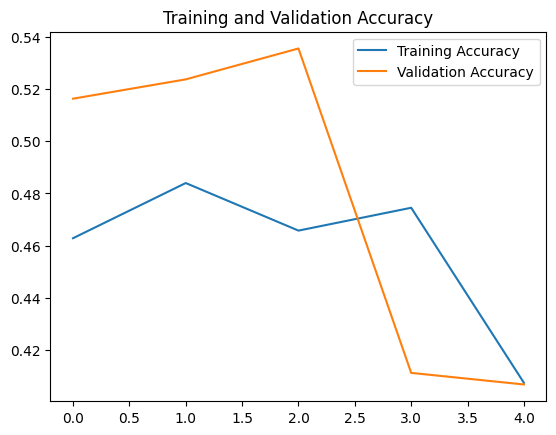

In [23]:
# Visualization of Training History
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

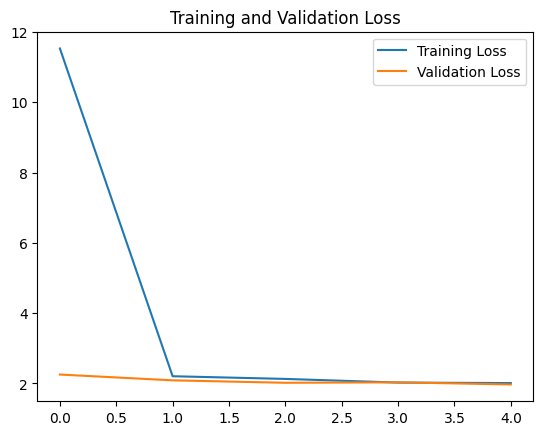

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

#Save model

In [25]:
model.save('/content/drive/MyDrive/Colab Notebooks/fruit-dta/trained_model.h5')
